In [2]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
from itertools import chain


from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1

In [4]:
# pressure 6.9e-3
# max, zero
ds = [
    [ufloat(14.9, 0.05), ufloat(14.1, 0.05)],
    [ufloat(14.8, 0.05), ufloat(14.0, 0.05)],
    [ufloat(14.7, 0.05), ufloat(14.0, 0.05)],
    [ufloat(14.7, 0.05), ufloat(14.05, 0.05)]
    # new dataz
    # [ufloat(13.0, 0.05), ufloat(12.35, 0.05)]
    # [ufloat(12.8, 0.05), ufloat(11.8, 0.05)]
    # [ufloat(14.7, 0.05), ufloat(14.05, 0.05)]
    # [ufloat(14.7, 0.05), ufloat(14.05, 0.05)]
    # [ufloat(14.7, 0.05), ufloat(14.05, 0.05)]
]  # cm, cm
frequencies = [
    20_000,
    50_000,
    80_000,
    100_000
    # new dataz
    # 20_000,

]  # Hz

lambdas = [abs(d1 - d2)*4/100 for d1, d2 in ds]  # m
k = [2 * np.pi / lam for lam in lambdas]  # /m
w = [2 * np.pi * f for f in frequencies]  # ~Hz
phase_vels = [*map(lambda a: a[0]*a[1], zip(lambdas, frequencies))]  # m/s
print(phase_vels)
# The phase velocity changes ok... BUT WHY WOULD A WAVE INFLUENCE THE TEMPERATURE OF THE PLASMA???

M = ufloat(39.95, 0.16) * sc.constants.atomic_mass
# Z = 18  # ???
Z = 1  # ???
gamma_e = 1
# kbT_e = [*map(lambda v: v**2 * M / (gamma_e * Z * BOLTZMANN_CONSTANT_JOULE) * BOLTZMANN_CONSTANT_ELECTRONVOLT, phase_vels)]  # eV
kbT_e = [*map(lambda v: v**2 * M / (gamma_e * Z * ELEMENTARY_CHARGE), phase_vels)]  # eV
kbT_e

[640.0000000000006+/-56.568542494923804, 1600.0000000000014+/-141.4213562373095, 2239.9999999999977+/-226.27416997969522, 2599.9999999999945+/-282.842712474619]


[0.16959593374703077+/-0.02998830197592323,
 1.0599745859189424+/-0.1874268873495202,
 2.077550188401119+/-0.41981098659220034,
 2.7989953909421907+/-0.609084281138181]

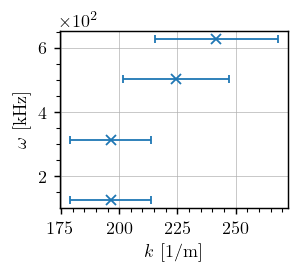

In [5]:
plt.errorbar(nom_vals(k), nom_vals(w)/1000, xerr=std_devs(k), marker='x', markersize=5, ls='')
plt.xlabel(r'$k$ [1/m]')
plt.ylabel(r'$\omega$ [kHz]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
plt.savefig('../figures/dispersion_relation.pdf')

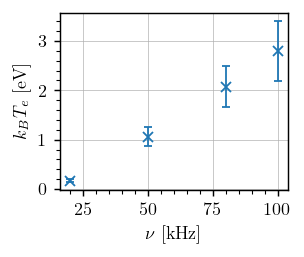

In [6]:
plt.errorbar(list(map(lambda f: f/1000, frequencies)), nom_vals(kbT_e), yerr=std_devs(kbT_e), marker='x', markersize=5, ls='')
plt.xlabel(r'$\nu$ [kHz]')
plt.ylabel(r'$k_B T_e$ [eV]')
plt.savefig('../figures/ion_acoustic_temperature.pdf')

## Compare with other T_e measurement method

In [7]:
def process(filename, headers, datas):
    header = np.loadtxt(filename, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
    headers.append(header)

    data = np.loadtxt(filename, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append(np.array((V_in_combined, I_out_combined, I_out_std_combined)))

In [8]:
all_headers = [[]]
all_datas = [[]]
for run in ["../data/ion_wave/run212.tsv"]:
    process(run, all_headers[0], all_datas[0])

# sort all datasets by specific key
for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    all_headers[i], all_datas[i] = zip(*sorted(zip(headers, datas), key=lambda c: c[0][-1]))

## Find V_{sp}, ln(I_{es})

In [9]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

2.73+/-0.09 0.000977+/-0.000010
T_e_run = (2.41±0.06)×10⁴, T_run = (2.08±0.05)×10⁰, n_e_run = (8.03±0.09)×10¹⁵


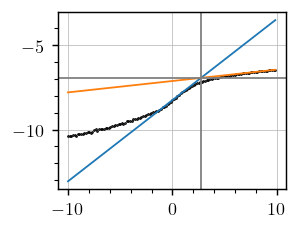

In [10]:
T_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
T = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
n_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))

for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    for j, (header, data) in enumerate(zip(headers, datas)):
        p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
        V_in, I_out, I_out_std = data

        dydx = np.gradient(np.log(I_out), V_in)
        threshold = 7e-2
        idx = np.abs(np.diff(dydx, prepend=0)) < threshold
        idx = np.logical_and(idx, V_in > 0)
        idx_B = set_all_between(np.logical_and(idx, V_in < 1.5))
        idx_C = set_all_between(np.logical_and(idx, V_in > 7))
        # idx_B = np.logical_and(0 < V_in, V_in < 3)
        # idx_C = V_in > 6

        coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
        coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
        fitfuncB = np.poly1d(coefsB)
        coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
        coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
        fitfuncC = np.poly1d(coefsC)

        x = np.linspace(V_in[0], V_in[-1])
        plt.scatter(V_in, np.log(I_out), c='k')
        plt.plot(x, fitfuncB(x))
        plt.plot(x, fitfuncC(x))

        V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
        I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
        print(V_sp, I_sp)
        plt.axvline(V_sp.n)
        plt.axhline(umath.log(I_sp).n)

        T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
        T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
        # TODO: verifier unitées
        n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
        print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
        T_e[i, j] = T_e_run
        T[i, j] = T_run
        n_e[i, j] = n_e_run

        # plt.gcf().delaxes(plt.gca())

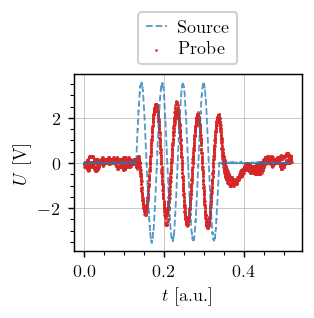

In [11]:
data_source = np.loadtxt("../data/ion_wave/wave1_source.tsv")
t0, t1, V_source = data_source[0], data_source[1], data_source[2:]
dt = t1 - t0
t = np.arange(0, len(V_source)*dt, dt)
plt.plot(t, sc.signal.savgol_filter(V_source, 10, 2), c='C0', ls='--', label='Source', alpha=0.75)
data_probe = np.loadtxt("../data/ion_wave/wave1_probe.tsv")
t0, t1, V_probe = data_probe[0], data_probe[1], data_probe[2:]
dt = t1 - t0
t = np.arange(0, len(V_probe)*dt, dt)
plt.scatter(t, V_probe, c='C3', label='Probe')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.2))
plt.xlabel('$t$ [a.u.]')
plt.ylabel('$U$ [V]')
plt.savefig('../figures/ion_acoustic_wave.pdf')